In [1]:
import Pkg
Pkg.add("Plots")
using Plots
Pkg.add("LinearAlgebra")

   Resolving package versions...
  No Changes to `C:\Users\Anastasia\.julia\environments\v1.10\Project.toml`
  No Changes to `C:\Users\Anastasia\.julia\environments\v1.10\Manifest.toml`
   Resolving package versions...
  No Changes to `C:\Users\Anastasia\.julia\environments\v1.10\Project.toml`
  No Changes to `C:\Users\Anastasia\.julia\environments\v1.10\Manifest.toml`


In [2]:
using LinearAlgebra

alpha, beta = 1, 1

func(x, y) = alpha * x^2 + beta * y ^ 2
f(x) = func(x[1],x[2])
x0 = [1.0, 1.0]

2-element Vector{Float64}:
 1.0
 1.0

In [3]:
using LinearAlgebra
function df(f, x::Vector{Float64}, i, h=1e-5)
    x_plus = copy(x)
    x_minus = copy(x)
    
    x_plus[i] += h
    x_minus[i] -= h
    
    df_dx = (f(x_plus) - f(x_minus)) / (2h)
    
    return df_dx
end

function gradient(f, x::Vector{Float64})
    grad = []
    for i in 1:length(x)
        push!(grad, df(f, x, i))
    end
    return grad
end

gradient (generic function with 1 method)

### Метод Свенна для локализации минимума

In [4]:
using LinearAlgebra

function swann_method(f, x0, h=0.1)
    first = x0
    second = x0 + h
    # если функция растет, меняем направление движения
    if f(second) > f(first)
        h = -h
        first, second = second, second + h
    end
    last = second + h
    
    # увеличиваем шаг движения, если функция уменьшается
    while f(last) < f(second)
        h *= 2
        first, second, last = second, last, last + h
    end
    # перепрыгнули далеко
    if second > last
        first, second, last = last, second, first
    end

    return first, last
end

swann_method (generic function with 2 methods)

### Метод золотого сечения для поиска минимума

In [5]:
using LinearAlgebra

function golden_section_search(f, a, b, eps=1e-5)
    phi = (sqrt(5) - 1) / 2 
    x1 = b - phi * (b - a)
    x2 = a + phi * (b - a)
    
    while abs(b - a) > eps
        if f(x1) <= f(x2)
            b = x2
        else
            a = x1
        end
        x1 = b - phi * (b - a)
        x2 = a + phi * (b - a)
    end
    
    return (a + b) / 2
end

golden_section_search (generic function with 2 methods)

## Метод сопряженных градиентов (Флэтчер-Ривс)

In [7]:
function conjugate_gradient(f, x0)
    eps1, eps2 = 1e-6, 1e-10
    x = x0
    prev_x = copy(x)
    grad = gradient(f, x)
    d = -grad
    trajectory = [x]
    
    while true
        prev_grad=copy(grad)
        l, r = swann_method(alpha -> f(x + alpha * d), 1e-7)
        alpha = golden_section_search(alpha -> f(x + alpha * d), l, r)
        x += alpha * d
        grad = gradient(f, x)

        if norm(x - prev_x) < eps1 || norm(f(x) - f(prev_x)) < eps2
            break
        end

        beta = dot(grad, grad) / dot(prev_grad, prev_grad)
        d = -grad + beta * d
        prev_x = copy(x)
        push!(trajectory, x)
    end
    
    return x, trajectory
end

x_min, trajectory = conjugate_gradient(f, x0)
print("Точка минимума: ", x_min, "; Количество итераций: ", length(trajectory)-1)

Точка минимума: [-20.00000002844816, -5.0000000067147665]; Количество итераций: 5

## Метод Полака-Рибьера 

In [7]:
#polak rebier
function polak_rebier(f, x0)
    eps1, eps2 = 1e-6, 1e-10
    x = x0
    prev_x = copy(x)
    grad = gradient(f, x)
    d = -grad
    trajectory = [x]
    
    while true
        prev_grad=copy(grad)
        l, r = swann_method(alpha -> f(x + alpha * d), 1e-7)
        alpha = golden_section_search(alpha -> f(x + alpha * d), l, r)
        x += alpha * d
        grad = gradient(f, x)

        if norm(x - prev_x) < eps1 || norm(f(x) - f(prev_x)) < eps2
            break
        end

        beta = dot(grad, (grad-prev_grad)) / dot(prev_grad, prev_grad)
        d = -grad + beta * d
        prev_x = copy(x)
        push!(trajectory, x)
    end
    
    return x, trajectory
end

x_min, trajectory = polak_rebier(f, x0)
print("Точка минимума: ", x_min, "; Количество итераций: ", length(trajectory)-1)

Точка минимума: [4.024507642289357e-17, 4.024507642289357e-17]; Количество итераций: 1

## Метод Хестенса-Стифеля

In [8]:
#hestens-stifel
function hestens_stifel(f, x0)
    eps1, eps2 = 1e-6, 1e-10
    x = x0
    prev_x = copy(x)
    grad = gradient(f, x)
    d = -grad
    trajectory = [x]
    
    while true
        prev_grad=copy(grad)
        prev_d = copy(d)
        l, r = swann_method(alpha -> f(x + alpha * d), 1e-7)
        alpha = golden_section_search(alpha -> f(x + alpha * d), l, r)
        x += alpha * d
        grad = gradient(f, x)

        if norm(x - prev_x) < eps1 || norm(f(x) - f(prev_x)) < eps2
            break
        end

        beta = dot(grad, (grad-prev_grad)) / dot(prev_d, (grad-prev_grad))
        d = -grad + beta * prev_d
        prev_x = copy(x)
        push!(trajectory, x)
    end
    
    return x, trajectory
end

x_min, trajectory = hestens_stifel(f, x0)
print("Точка минимума: ", x_min, "; Количество итераций: ", length(trajectory)-1)

Точка минимума: [3.3765155915688183e-6, 3.3765155915688183e-6]; Количество итераций: 1

## Метод Даяна

In [9]:
function dai_yuan(f, x0)
    eps1, eps2 = 1e-6, 1e-10
    x = x0
    prev_x = copy(x)
    grad = gradient(f, x)
    d = -grad
    trajectory = [x]
    
    while true
        prev_grad=copy(grad)
        l, r = swann_method(alpha -> f(x + alpha * d), 1e-7)
        alpha = golden_section_search(alpha -> f(x + alpha * d), l, r)
        x += alpha * d
        grad = gradient(f, x)

        if norm(x - prev_x) < eps1 || norm(f(x) - f(prev_x)) < eps2
            break
        end

        beta = dot(grad, (grad-prev_grad)) / dot(d, (grad-prev_grad))
        d = -grad + beta * d
        prev_x = copy(x)
        push!(trajectory, x)
    end
    
    return x, trajectory
end

x_min, trajectory = dai_yuan(f, x0)
print("Точка минимума: ", x_min, "; Количество итераций: ", length(trajectory)-1)

Точка минимума: [3.3765155915688183e-6, 3.3765155915688183e-6]; Количество итераций: 1

## Метод Диксона

In [10]:
function dickson(f, x0)
    eps1, eps2 = 1e-6, 1e-10
    x = x0
    prev_x = copy(x)
    grad = gradient(f, x)
    d = -grad
    trajectory = [x]
    
    while true
        prev_grad=copy(grad)
        l, r = swann_method(alpha -> f(x + alpha * d), 1e-7)
        alpha = golden_section_search(alpha -> f(x + alpha * d), l, r)
        x += alpha * d
        grad = gradient(f, x)

        if norm(x - prev_x) < eps1 || norm(f(x) - f(prev_x)) < eps2
            break
        end

        beta = dot(grad, grad) / dot(d, prev_grad)
        d = -grad + beta * d
        prev_x = copy(x)
        push!(trajectory, x)
    end
    
    return x, trajectory
end

x_min, trajectory = dickson(f, x0)
print("Точка минимума: ", x_min, "; Количество итераций: ", length(trajectory)-1)

Точка минимума: [-1.3505665596127883e-12, -1.3505665596127883e-12]; Количество итераций: 1

#### тестирование

Метод сопряженных градиентов:
 точка минимума: [-20.00000002844816, -5.0000000067147665]
 кол-во итераций = 5


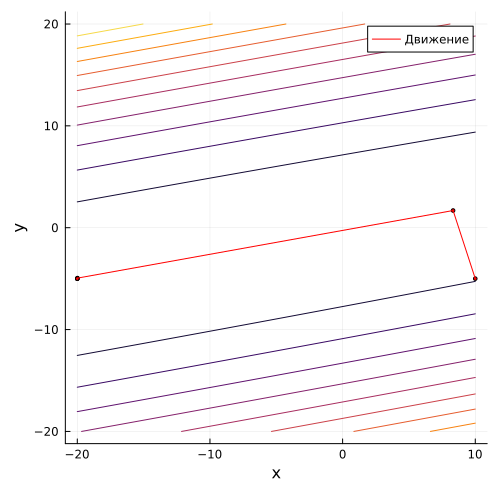

In [11]:
func(x, y) = (x-4*y)^2 +(y+5)^2
f(x) = func(x[1],x[2])
x0 = [10.0, -5.0] 

x = -20:0.1:10
y = -20:0.1:20
x_min, trajectory = conjugate_gradient(f, x0)
x_coords = [point[1] for point in trajectory]
y_coords = [point[2] for point in trajectory]
contour(x, y, (x, y) -> f([x, y]), levels = 10, xlabel="x", ylabel="y", colorbar=false, size=(500, 500))
scatter!(x_coords, y_coords, markersize=2, markershape=:circle, markercolor=:red, label = "")
p = plot!(x_coords, y_coords, label="Движение", line=:red)
println("Метод сопряженных градиентов:\n точка минимума: $x_min\n кол-во итераций = $(length(trajectory)-1)")
p

Метод Полака-Рибьера:
 точка минимума: [-19.999999998777607, -5.000000004984948]
 кол-во итераций = 3


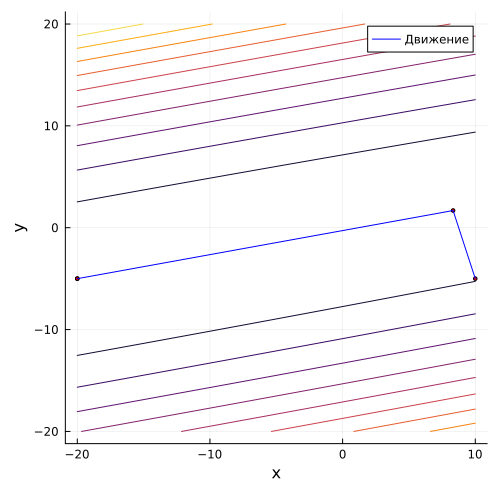

In [12]:
x_min, trajectory = polak_rebier(f, x0)
x_coords = [point[1] for point in trajectory]
y_coords = [point[2] for point in trajectory]
contour(x, y, (x, y) -> f([x, y]), levels = 10, xlabel="x", ylabel="y", colorbar=false, size=(500, 500))
scatter!(x_coords, y_coords, markersize=2, markershape=:circle, markercolor=:red, label = "")

p = plot!(x_coords, y_coords, label="Движение", line=:blue)
println("Метод Полака-Рибьера:\n точка минимума: $x_min\n кол-во итераций = $(length(trajectory)-1)")
p

Метод Хестенса-Стифеля:
 точка минимума: [-19.99999999880998, -5.000000004804756]
 кол-во итераций = 3


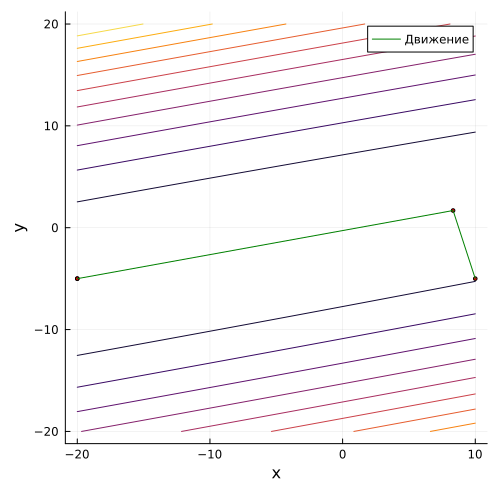

In [13]:
x_min, trajectory = hestens_stifel(f, x0)
x_coords = [point[1] for point in trajectory]
y_coords = [point[2] for point in trajectory]
contour(x, y, (x, y) -> f([x, y]), levels = 10, xlabel="x", ylabel="y", colorbar=false, size=(500, 500))
scatter!(x_coords, y_coords, markersize=2, markershape=:circle, markercolor=:red, label = "")

p = plot!(x_coords, y_coords, label="Движение", line=:green)
println("Метод Хестенса-Стифеля:\n точка минимума: $x_min\n кол-во итераций = $(length(trajectory)-1)")
p

Метод Дайана:
 точка минимума: [-19.99999999880998, -5.000000004804756]
 кол-во итераций = 3


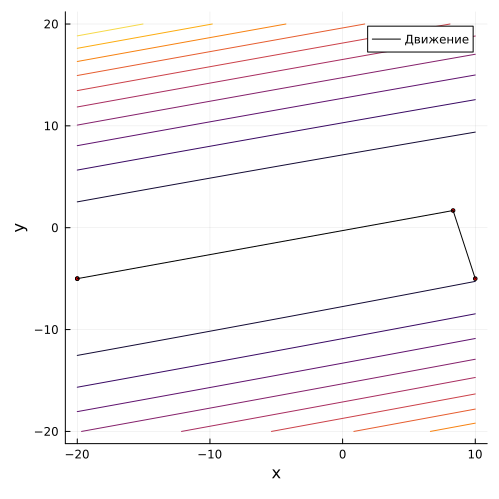

In [14]:
x_min, trajectory = dai_yuan(f, x0)
x_coords = [point[1] for point in trajectory]
y_coords = [point[2] for point in trajectory]
contour(x, y, (x, y) -> f([x, y]), levels = 10, xlabel="x", ylabel="y", colorbar=false, size=(500, 500))
scatter!(x_coords, y_coords, markersize=2, markershape=:circle, markercolor=:red, label = "")

p = plot!(x_coords, y_coords, label="Движение", line=:black)
println("Метод Дайана:\n точка минимума: $x_min\n кол-во итераций = $(length(trajectory)-1)")
p

Метод Диксона:
 точка минимума: [-19.99978251887352, -4.999948893121517]
 кол-во итераций = 365


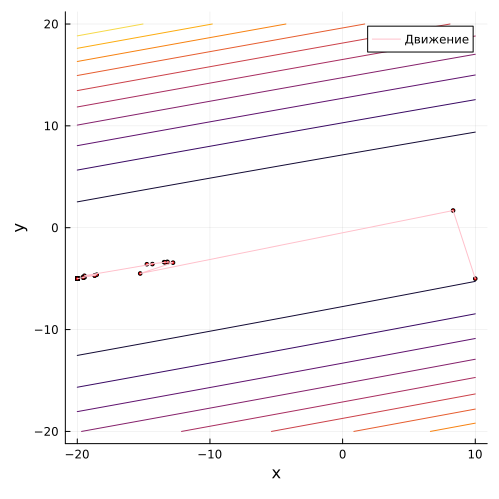

In [15]:
x_min, trajectory = dickson(f, x0)
x_coords = [point[1] for point in trajectory]
y_coords = [point[2] for point in trajectory]
contour(x, y, (x, y) -> f([x, y]), levels = 10, xlabel="x", ylabel="y", colorbar=false, size=(500, 500))
scatter!(x_coords, y_coords, markersize=2, markershape=:circle, markercolor=:red, label = "")

p = plot!(x_coords, y_coords, label="Движение", line=:pink)
println("Метод Диксона:\n точка минимума: $x_min\n кол-во итераций = $(length(trajectory)-1)")
p

### функция Розенброка

In [27]:
func(x, y) = (1-x)^2 +100*(y-x^2)^2
f(x) = func(x[1],x[2])
x0 = [5.0, 5.0]
print()

In [25]:
x = -2:0.1:2
y = -2:0.1:2
levels = []
for i in 1:10
    push!(levels, i^2*0.1)
end

Метод споряженных градиентов:
 точка минимума: [0.9999942529858412, 0.999988482684302]
 кол-во итераций = 9


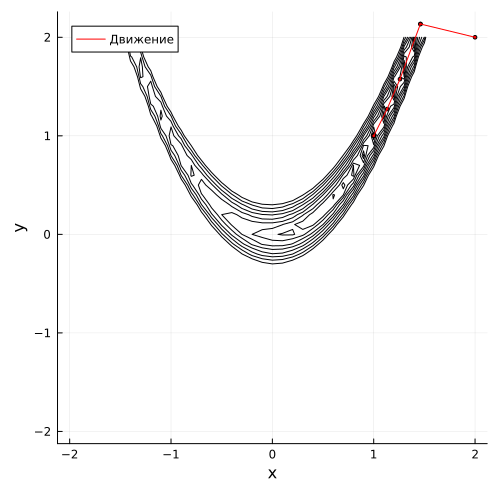

In [26]:
x_min, trajectory = conjugate_gradient(f, x0)
x_coords = [point[1] for point in trajectory]
y_coords = [point[2] for point in trajectory]
contour(x, y, (x, y) -> f([x, y]), levels = levels, xlabel="x", ylabel="y", colorbar=false, size=(500, 500))
scatter!(x_coords, y_coords, markersize=2, markershape=:circle, markercolor=:red, label = "")
p = plot!(x_coords, y_coords, label="Движение", line=:red)
println("Метод споряженных градиентов:\n точка минимума: $x_min\n кол-во итераций = $(length(trajectory)-1)")
p

Метод Полака-Рибьера:
 точка минимума: [0.9999999667944447, 0.9999999356877168]
 кол-во итераций = 13


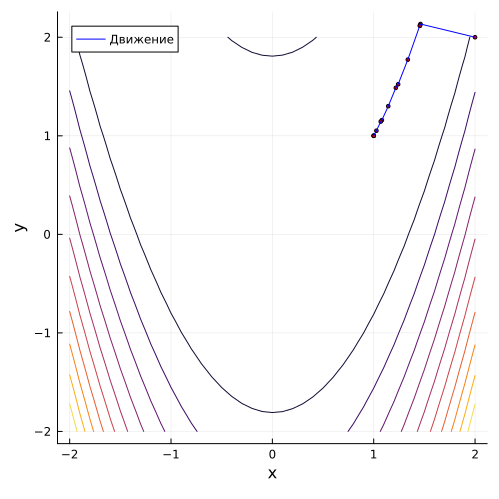

In [19]:
x_min, trajectory = polak_rebier(f, x0)
x_coords = [point[1] for point in trajectory]
y_coords = [point[2] for point in trajectory]
contour(x, y, (x, y) -> f([x, y]), levels = 10, xlabel="x", ylabel="y", colorbar=false, size=(500, 500))
scatter!(x_coords, y_coords, markersize=2, markershape=:circle, markercolor=:red, label = "")

p = plot!(x_coords, y_coords, label="Движение", line=:blue)
println("Метод Полака-Рибьера:\n точка минимума: $x_min\n кол-во итераций = $(length(trajectory)-1)")
p

Метод Хестенса-Стифеля:
 точка минимума: [1.0000000150814559, 1.0000000303704493]
 кол-во итераций = 9


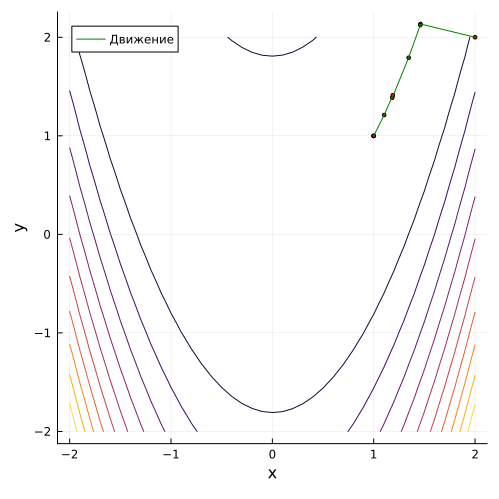

In [20]:
x_min, trajectory = hestens_stifel(f, x0)
x_coords = [point[1] for point in trajectory]
y_coords = [point[2] for point in trajectory]
contour(x, y, (x, y) -> f([x, y]), levels = 10, xlabel="x", ylabel="y", colorbar=false, size=(500, 500))
scatter!(x_coords, y_coords, markersize=2, markershape=:circle, markercolor=:red, label = "")

p = plot!(x_coords, y_coords, label="Движение", line=:green)
println("Метод Хестенса-Стифеля:\n точка минимума: $x_min\n кол-во итераций = $(length(trajectory)-1)")
p

Метод Дайана:
 точка минимума: [1.0000000150814559, 1.0000000303704493]
 кол-во итераций = 9


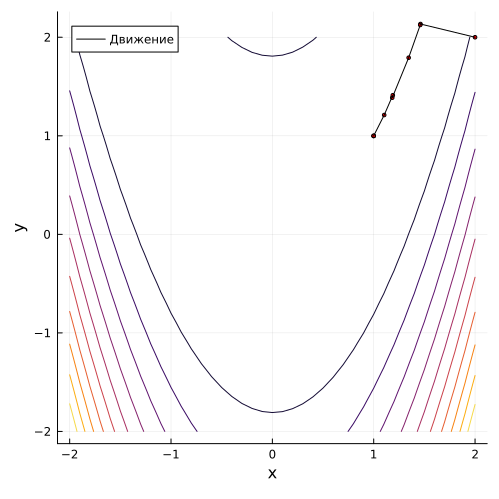

In [18]:
x_min, trajectory = dai_yuan(f, x0)
x_coords = [point[1] for point in trajectory]
y_coords = [point[2] for point in trajectory]
contour(x, y, (x, y) -> f([x, y]), levels = 10, xlabel="x", ylabel="y", colorbar=false, size=(500, 500))
scatter!(x_coords, y_coords, markersize=2, markershape=:circle, markercolor=:red, label = "")

p = plot!(x_coords, y_coords, label="Движение", line=:black)
println("Метод Дайана:\n точка минимума: $x_min\n кол-во итераций = $(length(trajectory)-1)")
p

Метод Диксона:
 точка минимума: [0.998285921003996, 0.9965697243308758]
 кол-во итераций = 39


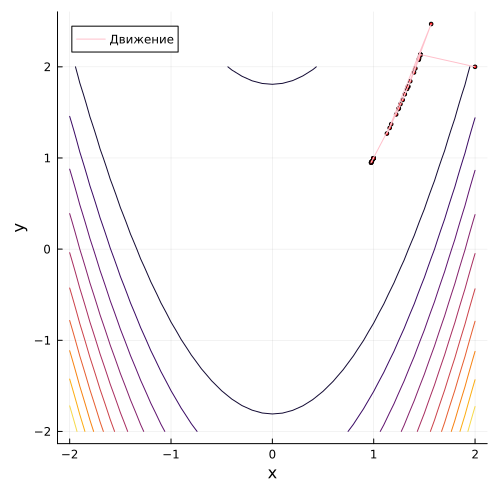

In [19]:
x_min, trajectory = dickson(f, x0)
x_coords = [point[1] for point in trajectory]
y_coords = [point[2] for point in trajectory]
contour(x, y, (x, y) -> f([x, y]), levels = 10, xlabel="x", ylabel="y", colorbar=false, size=(500, 500))
scatter!(x_coords, y_coords, markersize=2, markershape=:circle, markercolor=:red, label = "")

p = plot!(x_coords, y_coords, label="Движение", line=:pink)
println("Метод Диксона:\n точка минимума: $x_min\n кол-во итераций = $(length(trajectory)-1)")
p